# Training Logistic Regression via Stochastic Gradient Ascent

In [1]:
#Libraries Import
import json
import string
import numpy as np
import pandas as pd
from math import exp
from math import sqrt
import matplotlib.pyplot as plt
pd.set_option("Chained_Assignment",None)

In [2]:
#read dataframe
dataframe=pd.read_csv("amazon_baby_subset.csv")
dataframe.columns

Index(['name', 'review', 'rating', 'sentiment'], dtype='object')

In [3]:
import json
with open('important_words.json', 'r') as f: # Reads the list of most frequent words
    important_words = json.load(f)
important_words = [str(s) for s in important_words]

In [4]:
#replace null values with empty string
dataframe = dataframe.fillna({'review':''})

In [5]:
#remove punctuations
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator) 

dataframe["review_without_punctuation"] = dataframe['review'].apply(lambda x : remove_punctuation(x))
dataframe=dataframe[["name","review_without_punctuation",'sentiment']]

In [6]:
# For each word in important_words, we compute a count for the number of times the word occurs in the review.
for word in important_words:
    dataframe[word] = dataframe['review_without_punctuation'].apply(lambda s : s.split().count(word))

In [7]:
#train,validation data
with open('module-10-assignment-validation-idx.json') as validation_data_file:    
    validation_data_idx = json.load(validation_data_file)
with open('module-10-assignment-train-idx.json') as train_data_file:    
    train_data_idx = json.load(train_data_file)

train_data = dataframe.iloc[train_data_idx]
validation_data = dataframe.iloc[validation_data_idx]


In [8]:
def get_numpy_data(dataframe,features,label):
    dataframe['intercept'] = 1
    features = ['intercept'] + features
    feature_matrix = dataframe[features].values
    label_array=dataframe[label].values
    return(feature_matrix, label_array)

In [9]:
feature_matrix_train, sentiment_train = get_numpy_data(train_data, important_words, 'sentiment')
feature_matrix_valid, sentiment_valid = get_numpy_data(validation_data, important_words, 'sentiment') 

In [10]:
'''
feature_matrix: N * D
coefficients: D * 1
score: N * 1

predictions: N * 1

produces probablistic estimate for P(y_i = +1 | x_i, w).
estimate ranges between 0 and 1.
'''

def predict_probability(feature_matrix, coefficients):
   
    score = np.dot(feature_matrix, coefficients) # N * 1
    predictions = 1.0/(1+np.exp(-score))
    return predictions


In [11]:
def feature_derivative(errors, feature):  
    
    # Compute the dot product of errors and feature
    
    derivative = np.dot(np.transpose(errors), feature)
    
    # Return the derivative
    return derivative

In [12]:
def compute_avg_log_likelihood(feature_matrix, sentiment, coefficients):

    indicator = (sentiment==+1)
    scores = np.dot(feature_matrix, coefficients)
    logexp = np.log(1. + np.exp(-scores))
   
    # Simple check to prevent overflow
    mask = np.isinf(logexp)
    logexp[mask] = -scores[mask]   
    
    lp = np.sum( ( indicator.reshape(scores.shape)-1 )*scores - logexp )/len(feature_matrix)   
    
    return lp

In [13]:
j = 1                        # Feature number
i = 10                       # Data point number
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+1,:], coefficients)
indicator = (sentiment_train[i:i+1]==+1)

errors = indicator - predictions        
gradient_single_data_point = feature_derivative(errors, feature_matrix_train[i:i+1,j])
print ("Gradient single data point: %s" % gradient_single_data_point)
print ("           --> Should print 0.0")

Gradient single data point: 0.0
           --> Should print 0.0


In [14]:
j = 1                        # Feature number
i = 10                       # Data point start
B = 10                       # Mini-batch size
coefficients = np.zeros(194) # A point w at which we are computing the gradient.

predictions = predict_probability(feature_matrix_train[i:i+B,:], coefficients)
indicator = (sentiment_train[i:i+B]==+1)

errors = indicator - predictions        
gradient_mini_batch = feature_derivative(errors, feature_matrix_train[i:i+B,j])
print ("Gradient mini-batch data points: %s" % gradient_mini_batch)
print ("                --> Should print 1.0")

Gradient mini-batch data points: 1.0
                --> Should print 1.0


In [15]:
from math import sqrt
def logistic_regression_SG(feature_matrix, sentiment, initial_coefficients, step_size, batch_size, max_iter):
    
    log_likelihood_all = []
    
    # make sure it's a numpy array
    coefficients = np.array(initial_coefficients)
    
    # set seed=1 to produce consistent results
    np.random.seed(seed=1)
    
    # Shuffle the data before starting
    permutation = np.random.permutation(len(feature_matrix))
    feature_matrix = feature_matrix[permutation,:]
    sentiment = sentiment[permutation]

    i = 0 # index of current batch
    # Do a linear scan over data
    for itr in range(max_iter):
        # Predict P(y_i = +1|x_i,w) using your predict_probability() function
        # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,:]
        predictions = predict_probability(feature_matrix[i:(i+batch_size),:], coefficients)

        # Compute indicator value for (y_i = +1)
        # Make sure to slice the i-th entry with [i:i+batch_size]
        
        indicator = (sentiment[i:i+batch_size]==+1)

        # Compute the errors as indicator - predictions
        errors = indicator - predictions
        for j in range(len(coefficients)): # loop over each coefficient
            # Recall that feature_matrix[:,j] is the feature column associated with coefficients[j]
            # Compute the derivative for coefficients[j] and save it to derivative.
            # Make sure to slice the i-th row of feature_matrix with [i:i+batch_size,j]
            
            derivative = feature_derivative(errors, feature_matrix[i:i+batch_size,j]) 
                  # Compute the product of the step size, the derivative, and
            # the **normalization constant** (1./batch_size)
            
            coefficients[j] += step_size * derivative * 1. / batch_size

        # Checking whether log likelihood is increasing
        # Print the log likelihood over the *current batch*
        
        lp = compute_avg_log_likelihood(feature_matrix[i:i+batch_size,:], sentiment[i:i+batch_size],coefficients)
        log_likelihood_all.append(lp)
        
        if itr <= 15 or (itr <= 1000 and itr % 100 == 0) or (itr <= 10000 and itr % 1000 == 0) \
         or itr % 10000 == 0 or itr == max_iter-1:
            data_size = len(feature_matrix)
            print ('Iteration %*d: Average log likelihood (of data points  [%0*d:%0*d]) = %.8f' % \
                (int(np.ceil(np.log10(max_iter))), itr, \
                 int(np.ceil(np.log10(data_size))), i, \
                 int(np.ceil(np.log10(data_size))), i+batch_size, lp))  

        # if we made a complete pass over data, shuffle and restart
        i += batch_size
        if i+batch_size > len(feature_matrix):
            permutation = np.random.permutation(len(feature_matrix))
            feature_matrix = feature_matrix[permutation,:]
            sentiment = sentiment[permutation]
            i = 0                

    # We return the list of log likelihoods for plotting purposes.
    return coefficients, log_likelihood_all

In [16]:
# Checkpoint
sample_feature_matrix = np.array([[1.,2.,-1.], [1.,0.,1.]])
sample_sentiment = np.array([+1, -1])

coefficients, log_likelihood = logistic_regression_SG(sample_feature_matrix, sample_sentiment, np.zeros(3), step_size=1., batch_size=2, max_iter=2)
print ('-------------------------------------------------------------------------------------')
print ('Coefficients learned                 :', coefficients)
print ('Average log likelihood per-iteration :', log_likelihood)
if np.allclose(coefficients, np.array([-0.09755757,  0.68242552, -0.7799831]), atol=1e-3)\
  and np.allclose(log_likelihood, np.array([-0.33774513108142956, -0.2345530939410341])):
    # pass if elements match within 1e-3
    print ('-------------------------------------------------------------------------------------')
    print ('Test passed!')
else:
    print ('-------------------------------------------------------------------------------------')
    print ('Test failed')

Iteration 0: Average log likelihood (of data points  [0:2]) = -0.33774513
Iteration 1: Average log likelihood (of data points  [0:2]) = -0.23455309
-------------------------------------------------------------------------------------
Coefficients learned                 : [-0.09755757  0.68242552 -0.7799831 ]
Average log likelihood per-iteration : [-0.33774513108142956, -0.2345530939410341]
-------------------------------------------------------------------------------------
Test passed!


# QUIZ Training Logistic Regression via Stochastic Gradient Ascent

#### Question 1
In Module 3 assignment, there were 194 features (an intercept + one feature for each of the 193 important words). In this assignment, we will use stochastic gradient ascent to train the classifier using logistic regression. How does the changing the solver to stochastic gradient ascent affect the number of features?

__Ans__: Stays the same

#### Question 2
Recall from the lecture and the earlier assignment, the log likelihood (without the averaging term) is given by

How are the functions ℓℓ(w) and ℓℓ A(w) related?

__Ans__: b) ℓℓ A(w)=(1/N)⋅ℓℓ(w)

#### Question 3
Refer to the sub-section Computing the gradient for a single data point.

The code block above computed
for j = 1 and i = 10. Is this quantity a scalar or a 194-dimensional vector?


__Ans__: A scalar

#### Question 4
Refer to the sub-section Modifying the derivative for using a batch of data points.

The code block computed
for j = 10, i = 10, and B = 10. Is this a scalar or a 194-dimensional vector?



__Ans__: A scalar

#### Question 5
For what value of B is the term
the same as the full gradient? 
A numeric answer is expected for this question. Hint: consider the training set we are using now.

In [17]:
len(train_data)

47780

__Ans__: 47780

#### Question 6
For what value of batch size B above is the stochastic gradient ascent function logistic_regression_SG act as a standard gradient ascent algorithm? A numeric answer is expected for this question. Hint: consider the training set we are using now.

__Ans__: 47780

#### Question 7
When you set batch_size = 1, as each iteration passes, how does the average log likelihood in the batch change?

In [18]:
coefficients, log_likelihood = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=1, max_iter=10)

Iteration 0: Average log likelihood (of data points  [00000:00001]) = -0.25192908
Iteration 1: Average log likelihood (of data points  [00001:00002]) = -0.00000001
Iteration 2: Average log likelihood (of data points  [00002:00003]) = -0.12692771
Iteration 3: Average log likelihood (of data points  [00003:00004]) = -0.02969101
Iteration 4: Average log likelihood (of data points  [00004:00005]) = -0.02668819
Iteration 5: Average log likelihood (of data points  [00005:00006]) = -0.04332901
Iteration 6: Average log likelihood (of data points  [00006:00007]) = -0.02368802
Iteration 7: Average log likelihood (of data points  [00007:00008]) = -0.12686897
Iteration 8: Average log likelihood (of data points  [00008:00009]) = -0.04468879
Iteration 9: Average log likelihood (of data points  [00009:00010]) = -0.00000124


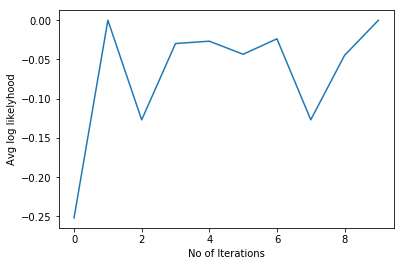

In [19]:
plt.ylabel("Avg log likelyhood")
plt.plot(log_likelihood)
plt.xlabel("No of Iterations")
plt.show()

__Ans__: Fluctuates

#### Question 8
When you set batch_size = len(feature_matrix_train), as each iteration passes, how does the average log likelihood in the batch change?


In [20]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

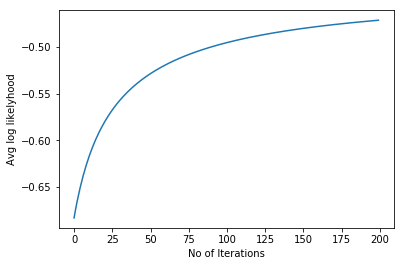

In [21]:
plt.ylabel("Avg log likelyhood")
plt.plot(log_likelihood_batch)
plt.xlabel("No of Iterations")
plt.show()

__Ans__: Increases

#### Question 9
Suppose that we run stochastic gradient ascent with a batch size of 100. How many gradient updates are performed at the end of two passes over a dataset consisting of 50000 data points?

__Ans__: 1000

In [22]:
step_size = 1e-1
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration   11: Average log likelihood (of data points  [01100:01

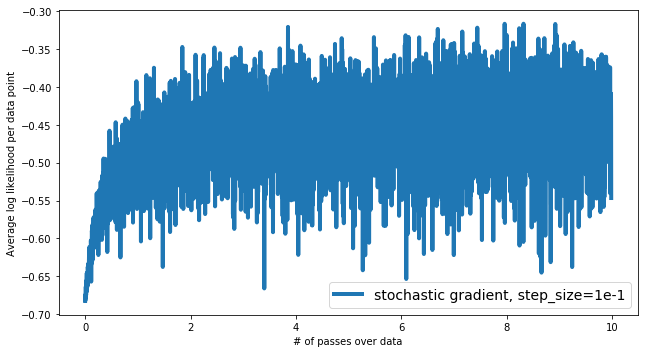

In [23]:
# Log likelihood plots for stochastic gradient ascent
import matplotlib.pyplot as plt
%matplotlib inline

def make_plot(log_likelihood_all, len_data, batch_size, smoothing_window=1, label=''):
    plt.rcParams.update({'figure.figsize': (9,5)})
    log_likelihood_all_ma = np.convolve(np.array(log_likelihood_all), \
                                        np.ones((smoothing_window,))/smoothing_window, mode='valid')
    plt.plot(np.array(range(smoothing_window-1, len(log_likelihood_all)))*float(batch_size)/len_data,
             log_likelihood_all_ma, linewidth=4.0, label=label)
    plt.rcParams.update({'font.size': 16})
    plt.tight_layout()
    plt.xlabel('# of passes over data')
    plt.ylabel('Average log likelihood per data point')
    plt.legend(loc='lower right', prop={'size':14})
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          label='stochastic gradient, step_size=1e-1')

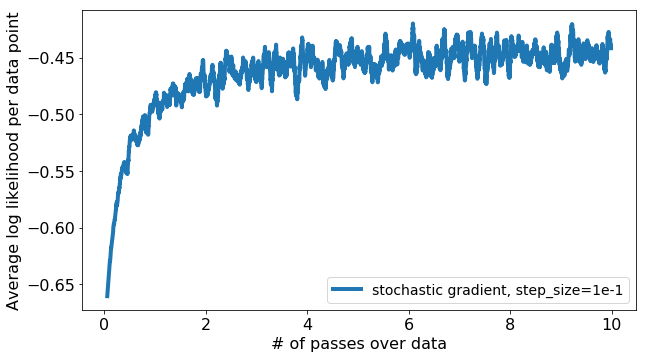

In [24]:
#Smoothing the stochastic gradient ascent curve

make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic gradient, step_size=1e-1')

#### Question 10
 Question 10
Refer to the section Stochastic gradient ascent vs gradient ascent.

In the first figure, how many passes does batch gradient ascent need to achieve a similar log likelihood as stochastic gradient ascent?

In [25]:
#Stochastic gradient ascent vs batch gradient ascent
step_size = 1e-1
batch_size = 100
num_passes = 200
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd, log_likelihood_sgd = logistic_regression_SG(feature_matrix_train, sentiment_train,
                                       initial_coefficients=np.zeros(194),
                                       step_size=1e-1, batch_size=100, max_iter=num_iterations)

Iteration     0: Average log likelihood (of data points  [00000:00100]) = -0.68251093
Iteration     1: Average log likelihood (of data points  [00100:00200]) = -0.67845294
Iteration     2: Average log likelihood (of data points  [00200:00300]) = -0.68207160
Iteration     3: Average log likelihood (of data points  [00300:00400]) = -0.67411325
Iteration     4: Average log likelihood (of data points  [00400:00500]) = -0.67804438
Iteration     5: Average log likelihood (of data points  [00500:00600]) = -0.67712546
Iteration     6: Average log likelihood (of data points  [00600:00700]) = -0.66377074
Iteration     7: Average log likelihood (of data points  [00700:00800]) = -0.67321231
Iteration     8: Average log likelihood (of data points  [00800:00900]) = -0.66923613
Iteration     9: Average log likelihood (of data points  [00900:01000]) = -0.67479446
Iteration    10: Average log likelihood (of data points  [01000:01100]) = -0.66501639
Iteration    11: Average log likelihood (of data point

In [26]:
coefficients_batch, log_likelihood_batch = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                        initial_coefficients=np.zeros(194),\
                                        step_size=5e-1, batch_size=len(feature_matrix_train), max_iter=200)

Iteration   0: Average log likelihood (of data points  [00000:47780]) = -0.68308119
Iteration   1: Average log likelihood (of data points  [00000:47780]) = -0.67394599
Iteration   2: Average log likelihood (of data points  [00000:47780]) = -0.66555129
Iteration   3: Average log likelihood (of data points  [00000:47780]) = -0.65779626
Iteration   4: Average log likelihood (of data points  [00000:47780]) = -0.65060701
Iteration   5: Average log likelihood (of data points  [00000:47780]) = -0.64392241
Iteration   6: Average log likelihood (of data points  [00000:47780]) = -0.63769009
Iteration   7: Average log likelihood (of data points  [00000:47780]) = -0.63186462
Iteration   8: Average log likelihood (of data points  [00000:47780]) = -0.62640636
Iteration   9: Average log likelihood (of data points  [00000:47780]) = -0.62128063
Iteration  10: Average log likelihood (of data points  [00000:47780]) = -0.61645691
Iteration  11: Average log likelihood (of data points  [00000:47780]) = -0.6

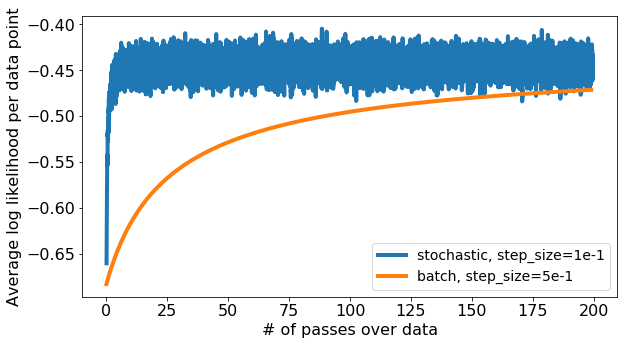

In [27]:
make_plot(log_likelihood_sgd, len_data=len(feature_matrix_train), batch_size=100,
          smoothing_window=30, label='stochastic, step_size=1e-1')
make_plot(log_likelihood_batch, len_data=len(feature_matrix_train), batch_size=len(feature_matrix_train),
          smoothing_window=1, label='batch, step_size=5e-1')

__Ans__: 150 passes or more

In [28]:
#Explore the effects of step sizes on stochastic gradient ascent
batch_size = 100
num_passes = 10
num_iterations = num_passes * int(len(feature_matrix_train)/batch_size)

coefficients_sgd = {}
log_likelihood_sgd = {}
for step_size in np.logspace(-4, 2, num=7):
    coefficients_sgd[step_size], log_likelihood_sgd[step_size] = logistic_regression_SG(feature_matrix_train, sentiment_train,\
                                       initial_coefficients=np.zeros(194),\
                                       step_size=step_size, batch_size=batch_size, max_iter=num_iterations)

Iteration    0: Average log likelihood (of data points  [00000:00100]) = -0.69313622
Iteration    1: Average log likelihood (of data points  [00100:00200]) = -0.69313170
Iteration    2: Average log likelihood (of data points  [00200:00300]) = -0.69313585
Iteration    3: Average log likelihood (of data points  [00300:00400]) = -0.69312487
Iteration    4: Average log likelihood (of data points  [00400:00500]) = -0.69313157
Iteration    5: Average log likelihood (of data points  [00500:00600]) = -0.69313113
Iteration    6: Average log likelihood (of data points  [00600:00700]) = -0.69311121
Iteration    7: Average log likelihood (of data points  [00700:00800]) = -0.69312692
Iteration    8: Average log likelihood (of data points  [00800:00900]) = -0.69312115
Iteration    9: Average log likelihood (of data points  [00900:01000]) = -0.69312811
Iteration   10: Average log likelihood (of data points  [01000:01100]) = -0.69311286
Iteration   11: Average log likelihood (of data points  [01100:01

Iteration  300: Average log likelihood (of data points  [30000:30100]) = -0.48245740
Iteration  400: Average log likelihood (of data points  [40000:40100]) = -0.46629313
Iteration  500: Average log likelihood (of data points  [02300:02400]) = -0.47223389
Iteration  600: Average log likelihood (of data points  [12300:12400]) = -0.52216798
Iteration  700: Average log likelihood (of data points  [22300:22400]) = -0.52336683
Iteration  800: Average log likelihood (of data points  [32300:32400]) = -0.46963453
Iteration  900: Average log likelihood (of data points  [42300:42400]) = -0.47883783
Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -0.46988191
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -0.46365531
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -0.36466901
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -0.51096892
Iteration 4769: Average log likelihood (of data points  [47600:47

Iteration 1000: Average log likelihood (of data points  [04600:04700]) = -4.02566802
Iteration 2000: Average log likelihood (of data points  [09200:09300]) = -21.21736128
Iteration 3000: Average log likelihood (of data points  [13800:13900]) = -1.78642149
Iteration 4000: Average log likelihood (of data points  [18400:18500]) = -23.32259959
Iteration 4769: Average log likelihood (of data points  [47600:47700]) = -6.12164089


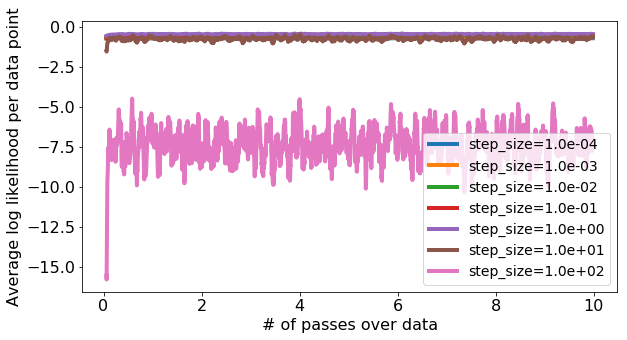

In [29]:
for step_size in np.logspace(-4, 2, num=7):
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

#### Question 11
Questions 11 and 12 refer to the section Plotting the log likelihood as a function of passes for each step size.

Which of the following is the worst step size? Pick the step size that results in the lowest log likelihood in the end.

__Ans__: 1e2

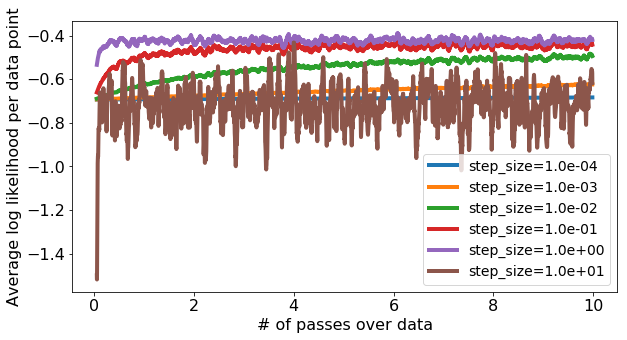

In [30]:
for step_size in np.logspace(-4, 2, num=7)[0:6]:
    make_plot(log_likelihood_sgd[step_size], len_data=len(train_data), batch_size=100,
              smoothing_window=30, label='step_size=%.1e'%step_size)

#### Question 12
Question 12
Questions 11 and 12 refer to the section Plotting the log likelihood as a function of passes for each step size.

Which of the following is the best step size? Pick the step size that results in the highest log likelihood in the end.

__Ans__: 1e0